In [64]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import pickle, os, glob
from EEG.info import info_exp
from EEG.converter import converter_mne
import mne
import numpy as np
import sys
import matplotlib.pyplot as plt
import itertools
from sklearn import metrics

In [65]:
# -*- coding: utf-8 -*-
"""
Created on Thu Mar 30 09:51:35 2017

@author: Egor Mikheev
@email: mail@nebesa.me
@package: github/thisroot/eeglab
"""

import pickle, os, glob
import numpy as np
import neo
import mne
from EEG.info import info_exp

class converter_mne:
    def __init__(self,data):
        self.obj = data
        self.list_tests = self.obj.info.list_tests
        self.num_tests = self.obj.info.num_tests
        self.labels = self.__get_labels()
        self.tmin = 0;
        self.tmax = (self.obj.data['time'][0]-1.)/1000
        
    def mne_info(self):
        return mne.create_info(ch_names = self.obj.info.chanels_names, 
                               sfreq = self.obj.info.frequency,
                               ch_types = self.obj.info.ch_types, 
                               montage = self.obj.info.montage)
        
    def train_raw(self):
        raw = np.concatenate(self.obj.data['data_train'],axis=1)
        return mne.io.RawArray(raw, self.mne_info()).set_eeg_reference(self.obj.info.chanels_names)
    
    def test_raw(self,idx):
        if(idx >= self.num_tests):
            print idx, " out the range: ", self.num_tests - 1
            return False
        raw = np.concatenate(self.obj.data['tests'][idx]['data_test'],axis=1)
        return mne.io.RawArray(raw, self.mne_info()).set_eeg_reference(self.obj.info.chanels_names)
    
    def __get_labels(self):
        labels = dict.fromkeys(self.obj.info.labels_names)
        for idx, i in enumerate(labels):
            labels[i] = idx
        labels.pop(u'удалено', None)
        return labels
        
        
    def train_events(self):
        events = []
        for i in range(0, len(self.obj.data['start'])):
            events.append([int(self.obj.data['start'][i]),0,int(self.obj.data['states_train'][i])])
        return np.array(events)
        
    def train_epochs(self):

        #return mne.EpochsArray(np.array(self.obj.data['data_train']), info=self.mne_info(), events=np.array(self.train_events()),
        #                 event_id=self.__get_labels())
        return mne.Epochs(self.train_raw(),np.array(self.train_events()),event_id=self.labels,add_eeg_ref=False, preload = True, tmin = self.tmin, tmax = self.tmax, baseline = None)
        #pass
    
    def test_events(self,idx):
        if(idx >= self.num_tests):
            print idx, " out the range: ", self.num_tests - 1
            return False
        events = []
        for i in range(0, len(self.obj.data['tests'][idx]['start'])):
            events.append([int(self.obj.data['tests'][idx]['start'][i]),0,int(self.obj.data['tests'][idx]['states_test'][i])])
        return np.array(events)
    
    def test_epochs(self,idx):
        if(idx >= self.num_tests):
            print idx, " out the range: ", self.num_tests - 1
            return False
        
        #return mne.EpochsArray(np.array(self.obj.data['tests'][idx]['data_test']), info=self.mne_info(), events=np.array(self.test_events(idx)),
                        # event_id=self.__get_labels())
        return mne.Epochs(self.test_raw(idx),np.array(self.test_events(idx)),event_id= self.labels, add_eeg_ref=False, preload = True, tmin = self.tmin, tmax = self.tmax, baseline = None)
        
    pass

In [66]:
root = "C:\\eeg\\01exp\\"
name = "20161129_DBS_001"

def load(path,name):
    with open(path + '/' + name, 'rb') as input:
        data = pickle.load(input)
        return data

In [67]:
test = load(root + name,'exp_data_aligned.cls')

In [68]:
test.getinfo()

Experiment status:  True ; Num tests:  12
Align status:  True
Respondent name:  Ольга Ветрова
Description: Эксперимент с обратной связью
Labels_names: [ удалено, отдых, левая, правая ]
Frequency: 1000
Count train activities:  45
Count tests activities: [ 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30 ]
Time of activity: 4500
Type_chanels: eeg  Montage: standard_1005
------------------------------------------------------------------
Chanels_names:
------------------------------------------------------------------
FC5        FT7        FC3        FCz        FC4        FT8       
T3         C3         Cz         T4         C4        
TP7        CP3        CPz        CP4        TP8       
FC1        FC2        FC6        P4         C5        
C1         C2         C6         P3         CP5       
CP1        CP2        CP6        POz       
------------------------------------------------------------------
List tests
------------------------------------------------------------------
2016112

In [69]:
data  = converter_mne(test)
epochs = data.train_epochs()

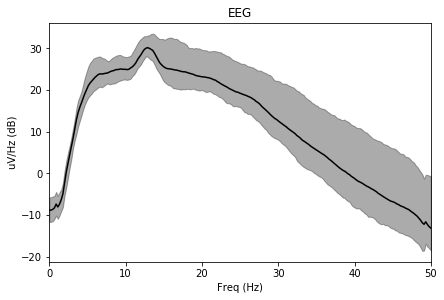

Figure(432x288)


In [70]:
#raw.filter(6,16,phase='zero',filter_length='auto', fir_window='hamming',l_trans_bandwidth='auto', h_trans_bandwidth='auto')
print epochs.plot_psd(area_mode='range', tmax=4.499,fmax=50.)

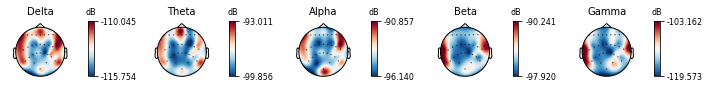

Figure(720x108)


In [71]:
print epochs.plot_psd_topomap()
picks = mne.pick_types(info=data.mne_info(), meg=False, eeg=True, misc=False)

In [72]:
mne.set_log_level(verbose = "ERROR")
# get test list
test_list = []
for i in range(0,data.num_tests):
    epochs_test = data.test_epochs(i)
    Y_test = epochs_test.events[:,-1]
    X_test = epochs_test.get_data()
    test_list.append({'Y_test':Y_test,'X_test':X_test})

In [73]:
import scipy.signal as spsig
def data_prep(data, sfreq, fmin, fmax):
    [b_high, a_high] = spsig.butter(4, float(fmin) / (sfreq / 2), 'high')
    [b_low, a_low] = spsig.butter(4, float(fmax) / (sfreq / 2), 'low')

    chunk_high = spsig.lfilter(b_high, a_high, data)
    chunk_low = spsig.lfilter(b_low, a_low, chunk_high)
    return chunk_low

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    pass

def plot_mult_conf_matrices(conf_matrices, method='mean', mode = 'plot'):
    if(len(conf_matrices) < 2):
        print "is not a matrices set"
        return 0
    if(conf_matrices[0].shape[0] != conf_matrices[0].shape[1]):
        print "is not a square matrix"
        return 0

    n = conf_matrices[0].shape[0]
    
    if(method == 'mean'):
        matrices = np.mean([confusion_matrix[n-j] for j in range(1,n)], axis = 0)
    elif(method == 'max'):
        matrices = np.max([confusion_matrix[n-j] for j in range(1,n)], axis = 0)
    elif(method == 'min'):
        matrices = np.min([confusion_matrix[n-j] for j in range(1,n)], axis = 0)
    else:
        print "incorrect method";
    if(mode == 'plot'):
        plt.figure()
        plot_confusion_matrix(matrices, classes=[u'Rest',u'left',u'right'],
                      title='Confusion matrix, without normalization')
    else:
        return matrices

## SCP decoder without addition filters

MAX: 1.0
MEAN: 0.802777777778
MIN: 0.566666666667
DISP: 0.129427752858
             precision    recall  f1-score   support

          1       1.00      1.00      1.00        10
          2       0.83      1.00      0.91        10
          3       1.00      0.80      0.89        10

avg / total       0.94      0.93      0.93        30

Confusion matrix, without normalization


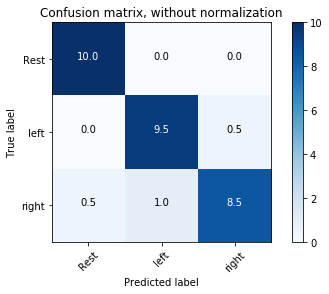

In [74]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from mne.decoding import CSP
from sklearn.multiclass import OneVsRestClassifier

Y_train = epochs.events[:,-1]
X_train = epochs.get_data()
X_train = data_prep(X_train, 1000, 6, 16)

# train classifier
svc = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg='ledoit_wolf', log=True)


X_train = csp.fit_transform(X_train, Y_train)
svc.fit(X_train, Y_train)

scores = []
classification_report = []
confusion_matrix = []
for i in range(0, len(test_list)):
    X_test = data_prep(test_list[i]['X_test'], 1000, 6, 16)
    X_test = csp.transform(X_test)
    scores.append(svc.score(X_test, test_list[i]['Y_test']))
    classification_report.append(metrics.classification_report(test_list[i]['Y_test'], svc.predict(X_test)))
    confusion_matrix.append(metrics.confusion_matrix(test_list[i]['Y_test'],svc.predict(X_test)))

print "MAX:", np.max(scores)
print "MEAN:", np.mean(scores)
print "MIN:", np.min(scores)
print "DISP:", np.std(scores)
print classification_report[0]


plot_mult_conf_matrices(confusion_matrix)

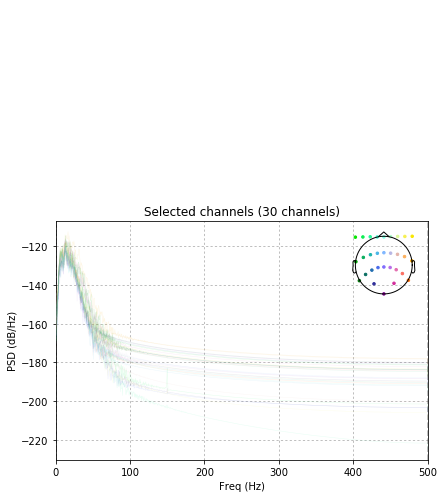

Figure(432x288)


In [112]:
from mne.preprocessing import maxwell_filter
raw = data.train_raw()
# Pick a subset of channels (here for speed reason)
picks = mne.pick_types(raw.info, eeg=True)
# Let's first check out all channel types
print raw.plot_psd(area_mode='range', tmax=10.0, picks=picks, average=False)

Удаление шумов линии электропередачи можно выполнить с помощью фильтра Notch непосредственно на объекте Raw, задав массив частоты, который нужно обрезать:

In [113]:
raw.notch_filter(np.arange(60, 241, 60), picks=picks, filter_length='auto',
                 phase='zero')
#print raw.plot_psd(area_mode='range', tmax=10.0, picks=picks, average=False)

<RawArray  |  None, n_channels x n_times : 30 x 202500 (202.5 sec), ~46.4 MB, data loaded>

Если вас интересуют только низкие частоты, ниже пиков шума линии электропередач, вы можете просто фильтровать низкочастотные данные.

In [114]:
# low pass filtering below 50 Hz
raw.filter(None, 50., h_trans_bandwidth='auto', filter_length='auto',
           phase='zero')
#print raw.plot_psd(area_mode='range', tmax=10.0, picks=picks, average=False)

<RawArray  |  None, n_channels x n_times : 30 x 202500 (202.5 sec), ~46.4 MB, data loaded>

High-pass filtering to remove slow drifts To remove slow drifts, you can high pass.

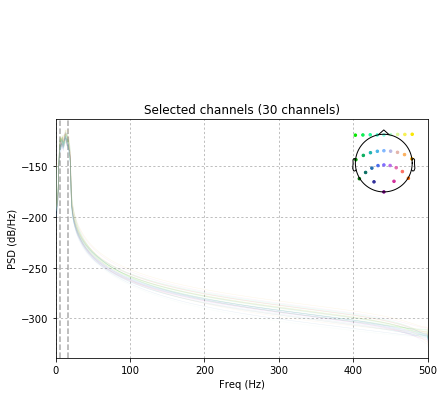

Figure(432x288)


In [115]:
raw.filter(1., None, l_trans_bandwidth='auto', filter_length='auto',
           phase='zero')

raw.filter(6, 16)
print raw.plot_psd(area_mode='range', tmax=10.0, picks=picks, average=False)

In [116]:
epochs = mne.Epochs(raw,data.train_events(),event_id=data.labels,add_eeg_ref=False, preload = True, tmin = data.tmin, tmax = data.tmax, proj=False, decim=1)

In [117]:
# get test list
test_list = []
for i in range(0,data.num_tests):
    raw_t = data.test_raw(i)
    raw_t.notch_filter(np.arange(60, 241, 60), picks=picks, filter_length='auto',
                 phase='zero')
    raw_t.filter(None, 50., h_trans_bandwidth='auto', filter_length='auto',
           phase='zero')
    raw_t.filter(1., None, l_trans_bandwidth='auto', filter_length='auto',
           phase='zero')
    raw.filter(6, 16)
    
    epochs_test = mne.Epochs(raw_t,data.test_events(i),event_id=data.labels,add_eeg_ref=False, preload = True, tmin = data.tmin, tmax = data.tmax, proj=False, decim=1)
    epochs_test = data.test_epochs(i)
    Y_test = epochs_test.events[:,-1]
    X_test = epochs_test.get_data()
    test_list.append({'Y_test':Y_test,'X_test':X_test})

MAX: 1.0
MEAN: 0.819444444444
MIN: 0.6
DISP: 0.125061713161
             precision    recall  f1-score   support

          1       1.00      1.00      1.00        10
          2       0.83      1.00      0.91        10
          3       1.00      0.80      0.89        10

avg / total       0.94      0.93      0.93        30

Confusion matrix, without normalization


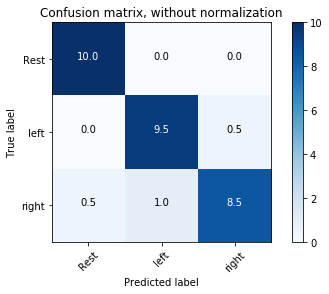

In [119]:
Y_train = epochs.events[:,-1]
X_train = epochs.get_data()
X_train = data_prep(X_train, 1000, 6, 16)

# train classifier
svc = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg='ledoit_wolf', log=True)


X_train = csp.fit_transform(X_train, Y_train)
svc.fit(X_train, Y_train)

scores = []
classification_report = []
confusion_matrix = []
for i in range(0, len(test_list)):
    X_test = test_list[i]['X_test']
    X_test = data_prep(X_test, 1000, 6, 16)
    X_test = csp.transform(X_test)
    scores.append(svc.score(X_test, test_list[i]['Y_test']))
    classification_report.append(metrics.classification_report(test_list[i]['Y_test'], svc.predict(X_test)))
    confusion_matrix.append(metrics.confusion_matrix(test_list[i]['Y_test'],svc.predict(X_test)))

print "MAX:", np.max(scores)
print "MEAN:", np.mean(scores)
print "MIN:", np.min(scores)
print "DISP:", np.std(scores)
print classification_report[0]


plot_mult_conf_matrices(confusion_matrix)